<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/4_GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Graph Isomorphism Network (GIN) из PyTorch Geometric для классификации узлов на датасете Bitcoin-OTC с обработкой признаков рёбер

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Необходимо выбрать среду выполнения с GPU: Runtime → Change runtime type → GPU

## 1. Установка зависимостей

In [1]:
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00


## 2. Импорт библиотек

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
import numpy as np

## 3. Загрузка и подготовка данных

Обработка признаков:
* Агрегация признаков рёбер через суммирование
* Нормализация всех признаков
* Явное преобразование типов данных

In [3]:
dataset = BitcoinOTC(root='data/BitcoinOTC', edge_window_size=10)
data = dataset[0]

Extracting data/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


### 3.1 Синтетические признаки узлов

In [4]:
degrees = np.zeros(data.num_nodes)
for edge in data.edge_index.t().tolist():
    degrees[edge[0]] += 1
data.x = torch.tensor(degrees, dtype=torch.float).view(-1, 1)
data.x = (data.x - data.x.mean()) / data.x.std()

### 3.2 Создание меток (3 класса)

In [5]:
labels = torch.zeros(data.num_nodes, dtype=torch.long)
q1 = np.quantile(degrees, 0.33)
q2 = np.quantile(degrees, 0.66)
labels[degrees > q2] = 2
labels[(degrees > q1) & (degrees <= q2)] = 1
data.y = labels

### 3.3 Обработка признаков рёбер

In [6]:
data.edge_attr = data.edge_attr.to(torch.float32)
data.edge_attr = (data.edge_attr - data.edge_attr.mean()) / data.edge_attr.std()

### 3.4 Разделение данных

In [7]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
indices = torch.randperm(data.num_nodes)
split = [0.6, 0.2, 0.2]
data.train_mask[indices[:int(split[0]*data.num_nodes)]] = True
data.val_mask[indices[int(split[0]*data.num_nodes):int((split[0]+split[1])*data.num_nodes)]] = True
data.test_mask[indices[int((split[0]+split[1])*data.num_nodes):]] = True

## 4. Определение модели GIN с обработкой признаков рёбер

Архитектура GIN:
* Два GIN-слоя с MLP внутри
* Batch Normalization и Dropout для регуляризации
* Объединение признаков узлов с агрегированными признаками рёбер

In [8]:
class BitcoinGIN(torch.nn.Module):
    def __init__(self, hidden_channels=64):
        super().__init__()

        # MLP для признаков узлов + рёбер
        self.node_mlp = Sequential(
            Linear(1 + 1, hidden_channels),  # 1 (узлы) + 1 (агрегированные рёбра)
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels)
        )

        # GIN слои
        self.conv1 = GINConv(self.node_mlp)
        self.conv2 = GINConv(Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels)
        ))

        # Классификатор
        self.lin = Linear(hidden_channels, 3)
        self.dropout = 0.5

    def forward(self, x, edge_index, edge_attr):
        # Агрегация признаков рёбер (сумма)
        row = edge_index[0]
        edge_aggregated = torch.zeros(x.size(0), dtype=torch.float32).to(x.device)
        edge_aggregated.scatter_add_(0, row, edge_attr.squeeze())

        # Объединение с признаками узлов
        x = torch.cat([x, edge_aggregated.view(-1, 1)], dim=1)

        # Первый GIN слой
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Второй GIN слой
        x = self.conv2(x, edge_index)
        return self.lin(x)


## 5. Инициализация модели

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BitcoinGIN(hidden_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

## 6. Обучение

In [10]:
def accuracy(pred, true, mask):
    return (pred[mask].argmax(dim=1) == true[mask]).sum().float() / mask.sum()

model.train()
train_losses = []
val_accuracies = []
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()



    # Валидация
    model.eval()
    with torch.no_grad():
        val_acc = accuracy(out, data.y, data.val_mask)

    if epoch % 30 == 0:
        print(f'Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}')

    train_losses.append(loss.item())
    val_accuracies.append(val_acc.item())

Epoch 000 | Loss: 1.1379 | Val Acc: 0.0000
Epoch 030 | Loss: 0.0066 | Val Acc: 1.0000
Epoch 060 | Loss: 0.0038 | Val Acc: 1.0000
Epoch 090 | Loss: 0.0034 | Val Acc: 1.0000
Epoch 120 | Loss: 0.0031 | Val Acc: 1.0000
Epoch 150 | Loss: 0.0030 | Val Acc: 1.0000
Epoch 180 | Loss: 0.0031 | Val Acc: 1.0000
Epoch 210 | Loss: 0.0032 | Val Acc: 1.0000
Epoch 240 | Loss: 0.0030 | Val Acc: 1.0000
Epoch 270 | Loss: 0.0030 | Val Acc: 1.0000


## 7. Тестирование

In [11]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_attr)
    test_acc = accuracy(out, data.y, data.test_mask)
    print(f'\nFinal Test Accuracy: {test_acc:.4f}')


Final Test Accuracy: 0.9983


## 8. Визуализация обучения:

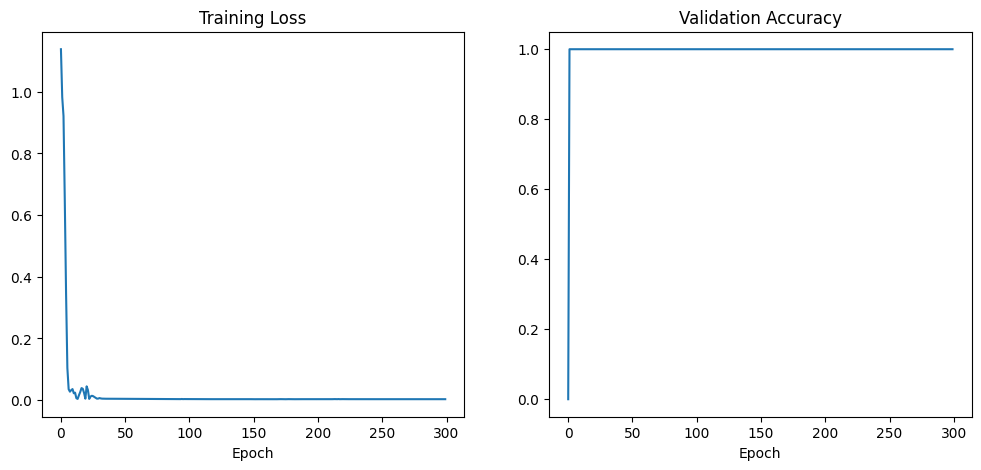

In [12]:
# После обучения:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()